In [1]:
import pickle
import pandas as pd
import seaborn as sns

In [2]:
air_df = pickle.load(open("air_df_1.p",'rb'))
open('air_df_1.p','rb').close

<function BufferedReader.close>

In [7]:
air_df.sort_values(by='Date',inplace=True)
df =air_df[['Date','Daily Max 8-hour Ozone Concentration']]
df.set_index('Date',inplace=True)

In [3]:
import plaidml.keras
plaidml.keras.install_backend()

from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [4]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
# load dataset
values = df.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 6)
# drop columns we don't want to predict
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
7,0.246377,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391
8,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957
9,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957,0.014493
10,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957,0.014493,0.246377
11,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957,0.014493,0.246377,0.188406


In [18]:
y = reframed.iloc[:,-1].values
X = reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)','var1(t+5)'], axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 7) (3100,) (500, 1, 7) (500,) (360, 1, 7) (360,)


In [21]:
# simple_rnn = Sequential()
# simple_rnn.add(SimpleRNN(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# simple_rnn.add(Dense(1))
# simple_rnn.compile(loss='mae', optimizer=RMSprop())

# #checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
# #                               , verbose=0
# #                               , save_best_only=True)
# earlystopper = EarlyStopping(monitor='val_loss'
#                              , patience=30
#                              , verbose=0)
# with open("simple_rnn.json", "w") as m:
#      m.write(simple_rnn.to_json())

# simple_rnn_history = simple_rnn.fit(train_X,train_y
#                                               , epochs=200
#                                               , validation_data=(val_X, val_y)
#                                               , verbose=2
#                                               , callbacks= [earlystopper]
#                                              )
# plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [22]:
# simple_lstm = Sequential()
# simple_lstm.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# simple_lstm.add(Dense(1))
# simple_lstm.compile(loss='mae', optimizer=RMSprop())

# #checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
# #                               , verbose=0
# #                               , save_best_only=True)
# earlystopper = EarlyStopping(monitor='val_loss'
#                              , patience=30
#                              , verbose=0)
# with open("simple_lstm.json", "w") as m:
#     m.write(simple_lstm.to_json())

# simple_lstm_history = simple_lstm.fit(train_X,train_y
#                                               , epochs=200
#                                               , validation_data=(val_X, val_y)
#                                               , verbose=2
#                                               , callbacks= [earlystopper]
#                                              )
# plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

Train on 3100 samples, validate on 500 samples
Epoch 1/200
 - 2s - loss: 0.2230 - val_loss: 0.0901
Epoch 2/200
 - 1s - loss: 0.0903 - val_loss: 0.0886
Epoch 3/200
 - 1s - loss: 0.0880 - val_loss: 0.0876
Epoch 4/200
 - 1s - loss: 0.0871 - val_loss: 0.0913
Epoch 5/200
 - 1s - loss: 0.0867 - val_loss: 0.0855
Epoch 6/200
 - 1s - loss: 0.0865 - val_loss: 0.0871
Epoch 7/200
 - 1s - loss: 0.0864 - val_loss: 0.0859
Epoch 8/200
 - 1s - loss: 0.0866 - val_loss: 0.0853
Epoch 9/200
 - 1s - loss: 0.0866 - val_loss: 0.0853
Epoch 10/200
 - 1s - loss: 0.0866 - val_loss: 0.0857
Epoch 11/200
 - 1s - loss: 0.0863 - val_loss: 0.0850
Epoch 12/200
 - 1s - loss: 0.0866 - val_loss: 0.0852
Epoch 13/200
 - 1s - loss: 0.0865 - val_loss: 0.0850
Epoch 14/200
 - 1s - loss: 0.0865 - val_loss: 0.0863
Epoch 15/200
 - 1s - loss: 0.0865 - val_loss: 0.0857
Epoch 16/200
 - 1s - loss: 0.0864 - val_loss: 0.0852
Epoch 17/200
 - 1s - loss: 0.0864 - val_loss: 0.0849
Epoch 18/200
 - 1s - loss: 0.0864 - val_loss: 0.0848
Epoch 19

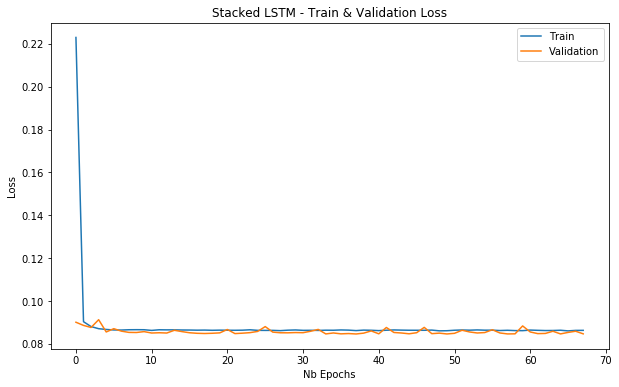

Minimum validation loss of 0.08459750354290009 reached at epoch 37


In [23]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

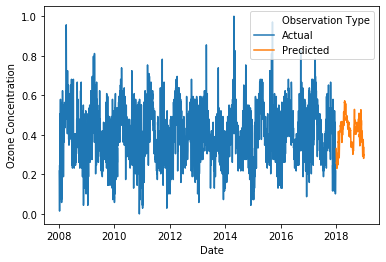

In [25]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':df.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':df.index[3107:-365]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':df.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me = pd.concat([train_data,val_data,test_data])

sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])

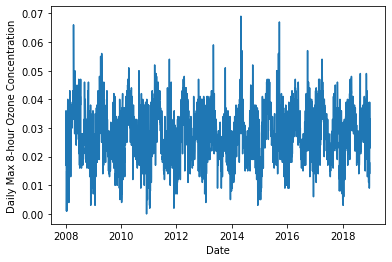

In [26]:
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])